In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd ..

/Share/home/shibinbin/projects/emaize


In [3]:
import h5py
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, DotProduct, Kernel, StationaryKernelMixin, ConstantKernel
from sklearn.preprocessing import StandardScaler

In [4]:
with h5py.File('output/random_select/10000', 'r') as f:
    X_gsm = f['/0/X'][:]
    X = f['/1/X'][:]

In [5]:
X_gsm = StandardScaler().fit_transform(X_gsm)
X = StandardScaler().fit_transform(X)

In [6]:
K0 = np.dot(X_gsm.T, X_gsm)
K0 /= np.trace(K0)/K0.shape[0]

In [9]:
S, U = np.linalg.eigh(K0)
X_pc = U[:, S > 0.1]
X_pc = StandardScaler().fit_transform(X_pc)

In [10]:
n_snps = 200
K_x = np.dot(X[:n_snps].T, X[:n_snps])
K_x /= np.trace(K_x)/K_x.shape[0]

In [11]:
import pandas as pd
def generate_parent_table(phenotype_file):
    phenotypes = pd.read_table(phenotype_file)
    pedigree = phenotypes['pedigree'].str.split('_', expand=True)
    pedigree.columns = ['f', 'X', 'm']
    phenotypes = pd.concat([phenotypes, pedigree], axis=1)
    phenotypes['number'] = np.arange(phenotypes.shape[0])
    parent_table = phenotypes.pivot_table(values='number', index=['m'], columns=['f'], dropna=False)
    male_ids = ['m%d' % i for i in range(1, parent_table.shape[0] + 1)]
    female_ids = ['f%d' % i for i in range(1, parent_table.shape[1] + 1)]
    parent_table = parent_table.loc[male_ids, female_ids]
    return parent_table
parent_table = generate_parent_table('emaize_data/phenotype/pheno_emaize.txt')
phenotypes = pd.read_table('emaize_data/phenotype/pheno_emaize.txt')

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 2] No such file or directory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


In [12]:
train_index = np.nonzero(phenotypes['type'] == 'training')[0]
test_index = np.nonzero(phenotypes['type'] == 'test')[0]

In [13]:
class PrecomputedKernel(Kernel):
    def __init__(self, K):
        self.K = K
    
    def __call__(self, X, Y=None, eval_gradient=False):
        X = np.atleast_2d(X)
        if Y is not None and eval_gradient:
            raise ValueError("Gradient can only be evaluated when Y is None.")
        if Y is None:
            K = self.K[X[:, 0], :][:, X[:, 0]]
            if eval_gradient:
                return K, np.ones((X.shape[0], X.shape[0], 0))
            else:
                return K
        else:
            return np.zeros((X.shape[0], Y.shape[0]))
        
    def diag(self, X):
        return np.diag(self.K[X[:, 0], :][:, X[:, 0]])
    
    def __repr__(self):
        return '{0}'.format(self.__class__.__name__)

    def is_stationary(self):
        return False

In [14]:
X_ind = np.arange(K0.shape[0])[:, np.newaxis]

In [43]:
kernel = PrecomputedKernel(K0)

In [71]:
kernel = PrecomputedKernel(K_x)*ConstantKernel() + PrecomputedKernel(K0)*ConstantKernel() + WhiteKernel()

In [72]:
trait = 'trait1'
X_ind = train_index[:, np.newaxis]
y = phenotypes.loc[train_index, trait].values
model_gp = GaussianProcessRegressor(kernel)
model_gp.fit(X_ind, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=PrecomputedKernel * 1**2 + PrecomputedKernel * 1**2 + WhiteKernel(noise_level=1),
             n_restarts_optimizer=0, normalize_y=False,
             optimizer='fmin_l_bfgs_b', random_state=None)

In [31]:
import GPy
trait = 'trait1'
kernel = GPy.kern.Precomputed(1, K0, name='K0') + GPy.kern.Precomputed(1, K_x, name='K_x')
X_ind = train_index[:, np.newaxis]
y = phenotypes.loc[train_index, trait].values
model_gp = GPy.models.GPRegression(X_ind, y[:, np.newaxis], kernel)
model_gp.optimize(messages=True)
model_gp

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i      f              |g|        
    35s19  0005   2.039075e+04   4.759213e+08 
 01m52s38  0016   1.389586e+03   1.452487e+02 
 03m03s43  0026   1.388340e+03   1.074916e-01 
 03m39s23  0031   1.388338e+03   1.566578e-05 
 04m29s16  0038   1.388338e+03   1.034588e-04 
Runtime:  04m29s16
Optimization status: Converged



GP_regression.,value,constraints,priors
sum.K0.variance,0.469567355834,+ve,
sum.K_x.variance,3.93044417852e-08,+ve,
Gaussian_noise.variance,0.0825781099593,+ve,


In [61]:
model_gp.log_likelihood

-1388.3376845398689

In [45]:
model_gp.parameter_names()

['sum.K0.variance', 'sum.K_x.variance', 'Gaussian_noise.variance']

In [52]:
np.std(y)**2

0.96723547380610642

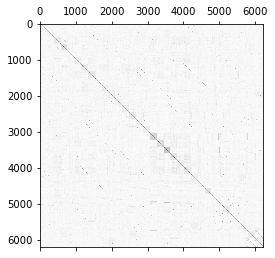

In [60]:
matshow(K_x, cmap=cm.Greys)

In [55]:
print(model_gp.param_array/model_gp.param_array.sum())

[  8.50441327e-01   7.11849348e-08   1.49558602e-01]


In [51]:
model_gp['sum.K0.variance'].values

array([ 0.46956736])

In [32]:
y_mean, y_var = model_gp.predict(X_ind)

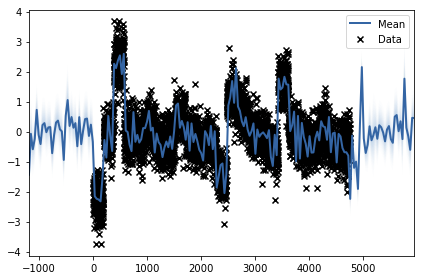

In [27]:
fig = model_gp.plot(plot_density=True)

In [38]:
model_gp.log_prior

<bound method GPRegression.log_prior of <GPy.models.gp_regression.GPRegression object at 0x2b3f38310a50>>

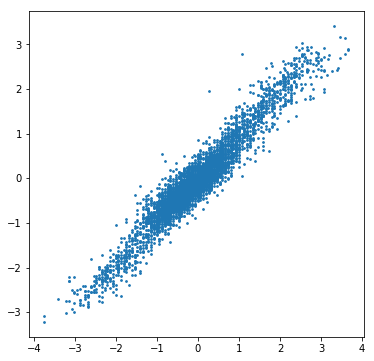

In [33]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.ravel(y), np.ravel(y_mean), s=3)

In [36]:
from scipy.stats import pearsonr
from sklearn.metrics import r2_score

In [37]:
print('pcc = %f'%pearsonr(np.ravel(y), np.ravel(y_mean))[0])
print('r2 = %f'%r2_score(np.ravel(y), np.ravel(y_mean)))

pcc = 0.959321
r2 = 0.920262


In [73]:
model_gp.kernel_.get_params()

{'k1': PrecomputedKernel * 0.00316**2 + PrecomputedKernel * 0.685**2,
 'k1__k1': PrecomputedKernel * 0.00316**2,
 'k1__k1__k1': PrecomputedKernel,
 'k1__k1__k1__K': array([[ 1.15067565,  0.15382577,  0.35721543, ..., -0.06183377,
         -0.03827307, -0.13382129],
        [ 0.15382577,  0.78464526,  0.17636696, ..., -0.03901742,
         -0.01564296,  0.09641298],
        [ 0.35721543,  0.17636696,  0.78527719, ...,  0.16574334,
         -0.01515922,  0.30155325],
        ..., 
        [-0.06183377, -0.03901742,  0.16574334, ...,  0.98137337,
          0.38595068,  0.50313467],
        [-0.03827307, -0.01564296, -0.01515922, ...,  0.38595068,
          0.61805105,  0.31799611],
        [-0.13382129,  0.09641298,  0.30155325, ...,  0.50313467,
          0.31799611,  2.1153028 ]], dtype=float32),
 'k1__k1__k2': 0.00316**2,
 'k1__k1__k2__constant_value': 9.9999999999999974e-06,
 'k1__k1__k2__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2': PrecomputedKernel * 0.685**2,
 'k1__k2__k1'

In [78]:
model_gp.predict(train_index[:, np.newaxis], return_std=True)

(array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 array([ 0.74305076,  0.74302703,  0.7430238 , ...,  0.7430447 ,
         0.74307331,  0.74304866]))

In [16]:
from sklearn.linear_model import Ridge

In [154]:
n_snps = 1000
X_mixed = np.concatenate([X[:n_snps, :].T, X_pc], axis=1)
#X_mixed = X_pc

traits = ('trait1', 'trait2', 'trait3')

In [161]:
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from tqdm import tqdm_notebook

trait = 'trait1'
kfold = KFold(10, shuffle=True)
metrics = {'r2': [], 'pcc': []}
pbar = tqdm_notebook(total=10)
y = phenotypes.loc[train_index, trait].values
for inner_train_index, valid_index in kfold.split(X_mixed[train_index]):
    X_inner_train, X_valid = X_mixed[inner_train_index], X_mixed[valid_index]
    y_inner_train, y_valid = y[inner_train_index], y[valid_index]
    model = Ridge(alpha=10.0)
    model.fit(X_inner_train, y_inner_train)
    y_pred = model.predict(X_valid)
    metrics['r2'].append(r2_score(y_valid, y_pred))
    metrics['pcc'].append(pearsonr(y_valid, y_pred)[0])
    pbar.update(1)
pbar.close()

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.3424137175e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.24959800682e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 4.32928324301e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.83712013274e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.87256839929e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.lin

In [156]:
y_pred = {}
for trait in traits:
    ridge = Ridge(10.0)
    y = phenotypes.loc[train_index, trait].values
    ridge.fit(X_mixed[train_index], y)
    ridge.score(X_mixed[train_index], y)
    y_pred[trait] = ridge.predict(X_mixed[test_index])  

/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.82780989128e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)
/dev/shm/shibinbin/anaconda2/lib/python2.7/site-packages/scipy/linalg/basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 3.82780633856e-08
  ' condition number: {}'.format(rcond), RuntimeWarning)


In [157]:
metrics

{'pcc': [0.95251447857980842,
  0.95149365957605425,
  0.94708998629579388,
  0.94923173442543074,
  0.95666581755017555,
  0.94948099054986068,
  0.95270421545588879,
  0.94587527481545808,
  0.95277132439436574,
  0.94910838843871159],
 'r2': [0.90711901373884185,
  0.90519073267570804,
  0.89690095438929751,
  0.90095940665412222,
  0.91440664571712793,
  0.90041744397862167,
  0.90748006592826036,
  0.8933216624712107,
  0.90630214183098623,
  0.90035430298443042]}

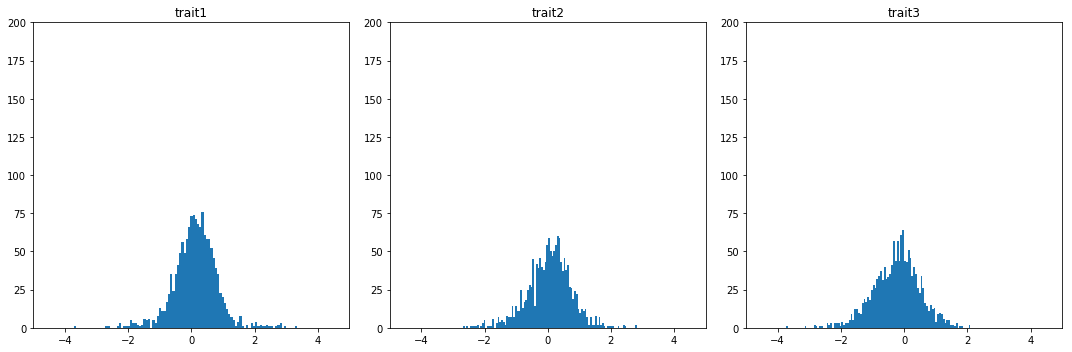

In [153]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, trait in enumerate(traits):
    ax[i].hist(np.ravel(y_pred[trait]), bins=100)
    ax[i].set_title(trait)
    ax[i].set_xlim(-5, 5)
    ax[i].set_ylim(0, 200)
plt.tight_layout()

In [142]:
y_pred

{'trait1': array([-1.89138579, -2.10756993, -1.56257021, ..., -0.83113319,
        -0.20427628,  0.05966152], dtype=float32),
 'trait2': array([-0.47058818, -0.18939999, -0.17781401, ..., -1.07000852,
        -0.90288371, -2.52743506], dtype=float32),
 'trait3': array([-1.21130466, -1.0886265 , -1.43386519, ...,  1.53932071,
         0.38770479, -1.30842602], dtype=float32)}

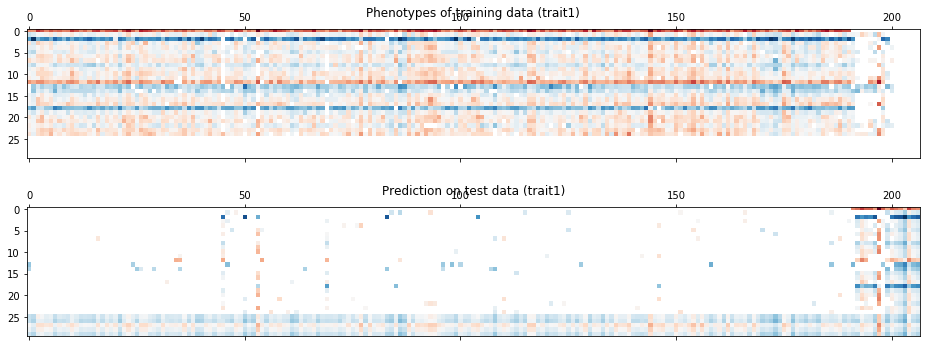

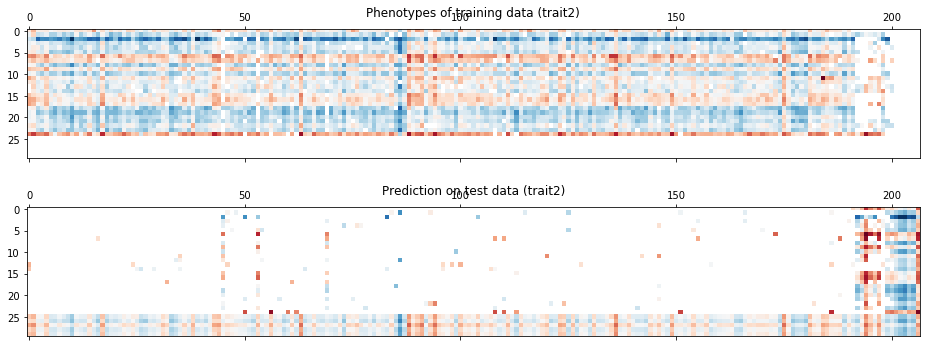

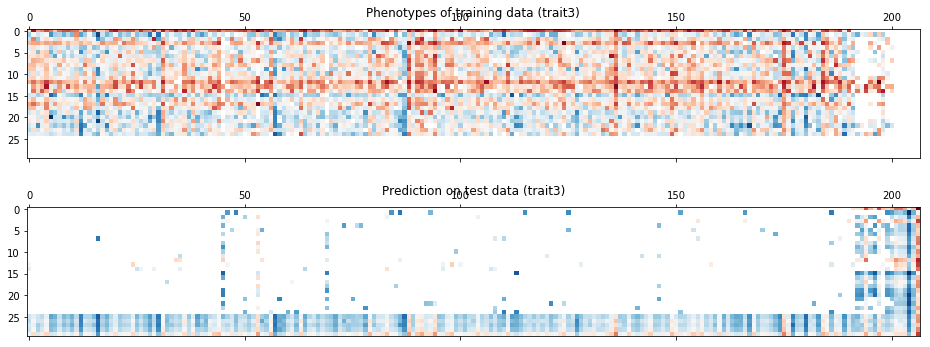

In [152]:
def normalize_phenotype(x, range_pheno=4.0):
    return (np.clip(x, -range_pheno, range_pheno) + range_pheno)/2.0/range_pheno
for trait in traits:
    pred_matrix = np.full(phenotypes.shape[0], np.nan)
    pred_matrix[test_index] = np.ravel(y_pred[trait])
    pred_matrix = np.take(pred_matrix, parent_table)
    true_matrix = np.take(np.ravel(phenotypes[trait].values), parent_table)
    
    fig, ax = subplots(2, 1, figsize=(16, 6))
    ax[0].matshow(normalize_phenotype(true_matrix), cmap=cm.RdBu)
    ax[0].set_title('Phenotypes of training data (%s)'%trait)

    ax[1].matshow(normalize_phenotype(pred_matrix), cmap=cm.RdBu)
    ax[1].set_title('Prediction on test data (%s)'%trait)

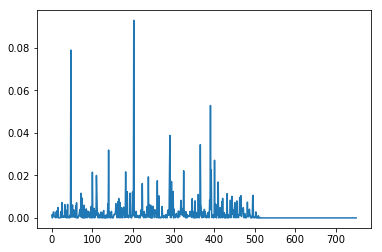

In [113]:
plot(ridge.coef_**2)

In [158]:
import scipy

In [159]:
scipy.linalg.solve?

In [65]:
X[:, train_index]

array([[-0.24476613, -0.23985144, -0.24365933, ..., -0.23307993,
        -0.23199691, -0.23379561],
       [-0.24476613, -0.23985144, -0.24365933, ..., -0.23307993,
        -0.23199691, -0.23379561],
       [-0.24476613, -0.23985144, -0.24365933, ..., -0.23307993,
        -0.23199691, -0.23379561],
       ..., 
       [-0.24476613,  3.99033308, -0.24365933, ..., -0.23307993,
         4.14530373, -0.23379561],
       [-0.24476613, -0.23985144, -0.24365933, ..., -0.23307993,
        -0.23199691, -0.23379561],
       [-0.24476613, -0.23985144, -0.24365933, ..., -0.23307993,
        -0.23199691, -0.23379561]], dtype=float32)

In [67]:
y = phenotypes.loc[train_index, trait].values

In [78]:
from scipy.stats import linregress
import scipy

In [110]:
linregress(X[0, train_index], y)

LinregressResult(slope=0.14679961815101641, intercept=-0.084760269853732764, rvalue=0.1964534108100324, pvalue=1.4277695449822817e-42, stderr=0.010628710144454045)

In [116]:
def slope_test(x, y):
    N = x.shape[0]
    df = N - 2
    xm = x.mean()
    ym = y.mean()
    ssx = np.sum((x - xm)**2)
    ssy = np.sum((y - ym)*(x - xm))
    #w = (x.dot(y) - xm*ym)/(x.dot(x) + xm**2)
    w = ssy/ssx
    b = ym - w*xm
    y_pred = w*x + b
    ssto = np.sum((y - ym)**2)
    sse = np.sum((y - y_pred)**2)
    ssr = ssto - sse
    f = ssr/(sse/(N - 2))
    t = w/(np.sqrt(ssto/(N - 2)/ssx))
    return w, b, f, scipy.stats.f.sf(f, 1, N - 2), t, 2.0*scipy.stats.t.sf(t, N - 2), sse/(N - 1)
slope_test(X[0, train_index], y)

(0.1467996091328351,
 -0.084760268114162263,
 190.76062506458729,
 1.4277658695689033e-42,
 13.542466756741737,
 5.0225319880158123e-41,
 0.93010168855594877)

In [132]:
def fast_linregress(X, y):
    N, M = X.shape
    DF = M - 2
    print(N, M, DF)
    
    y = y[np.newaxis, :]
    xm = X.mean(axis=1)[:, np.newaxis]
    ym = y.mean()
    ssx = np.sum((X - xm)**2, axis=1)[:, np.newaxis]
    ssxy = np.sum((y - ym)*(X - xm), axis=1)[:, np.newaxis]
    w = ssxy/ssx
    b = ym - w*xm
    y_estim = w*X + b
    print(ssx.shape, ssxy.shape, w.shape, b.shape, y_estim.shape)
    ssto = np.sum((y - ym)**2, axis=1)
    sse = np.sum((y - y_estim)**2, axis=1)
    ssr = ssto - sse
    f = ssr/(sse/DF)
    t = w/(np.sqrt(ssto/DF/ssx))
    return w, b, f, scipy.stats.f.sf(f, 1, DF), t, 2.0*scipy.stats.t.sf(np.abs(t), DF)
fast_linregress(X[:3, train_index], y)

(3, 4754, 4752)
((3, 1), (3, 1), (3, 1), (3, 1), (3, 4754))


(array([[ 0.14679944],
        [ 0.01703542],
        [-0.00242349]]), array([[-0.08476019],
        [-0.05642754],
        [-0.05642958]]), array([  1.90760620e+02,   1.35856864e+00,   2.87437656e-02]), array([  1.42776955e-42,   2.43844204e-01,   8.65379236e-01]), array([[ 13.54245872],
        [  1.16541075],
        [ -0.16953947]]), array([[  5.02306097e-41],
        [  2.43911263e-01],
        [  8.65379543e-01]]))

In [122]:
%pdb 1

Automatic pdb calling has been turned ON


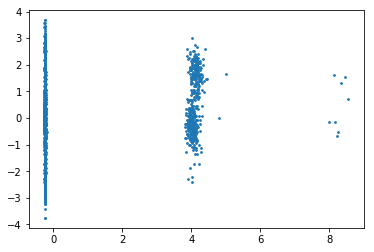

In [99]:
scatter(X[0, train_index], y, s=3)

In [88]:
y

array([-1.74610282, -1.67924837, -2.7489196 , ...,  0.25953072,
       -0.20845044, -0.47586824])